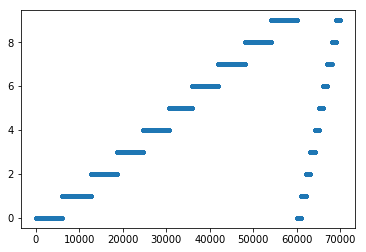

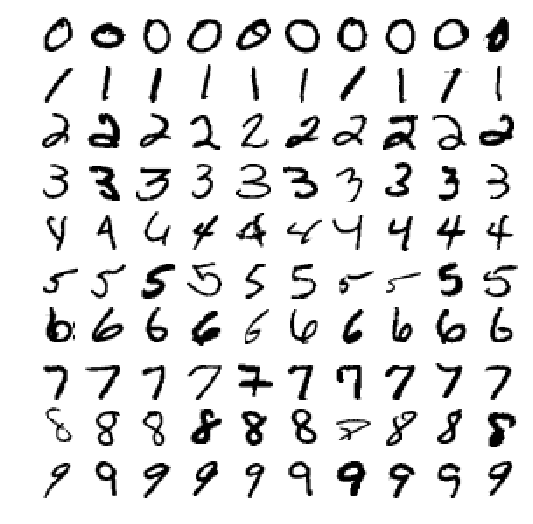

In [94]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.autograd
from torch.autograd import Variable
import scipy.io as sio

mnist_path = "data/mnist-original.mat"
mnist_raw = sio.loadmat(mnist_path)
mnist = {
        "data": mnist_raw["data"].T,
        "target": mnist_raw["label"][0],
        "COL_NAMES": ["label", "data"],
        "DESCR": "mldata.org dataset: mnist-original",
    }


features_data = mnist['data'].copy()
target_data = mnist['target'].copy()

plt.plot(target_data, '.')
plt.show()

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")


plt.figure(figsize=(9,9))
example_images = np.r_[features_data[:12000:600], features_data[13000:30600:600], features_data[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

features = Variable(torch.from_numpy(features_data).double(),requires_grad=False)
target = Variable(torch.LongTensor(target_data),requires_grad=False)

features = features / 255

features_test  =  features[60000:70000]
target_test =  target[60000:70000] 

features =  features[0:60000]
target =  target[0:60000] 

In [95]:
def draw_neural_net(ax, left, right, bottom, top, layer_sizes, bias=0, draw_edges=True):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
        - bias : Boolean
            Draw an extra bias node at each layer
        - draw_edges : Boolean
            If false, omit edge connections
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes)+bias)
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        bias_node = (bias if n<len(layer_sizes)-1 else 0)
        for m in range(layer_size+bias_node ):
            node_color = 'w' if m<layer_size else 'b'
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/8.,
                                color=node_color, ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    if draw_edges:
        for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
            layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
            for m in range(layer_size_a+bias):
                for o in range(layer_size_b):
                    line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                      [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], 
                                      c='k')
                    ax.add_artist(line)

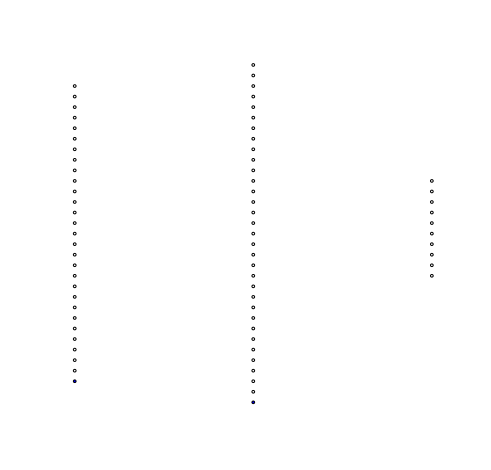

In [122]:
input_length = features.shape[1]
instance_size = features.shape[0]
sizes = [input_length,32,10]

g = torch.sigmoid
D = len(sizes)
Weight = []
Bias = []
Func = []
sm = torch.nn.Softmax(dim=0)
identity = lambda x: x

for i in range(D-1):
    
    # For layer i, Weights are a S_{i+1} \times S_{i} matrix
    W = Variable(torch.randn(sizes[i+1],sizes[i]).double(), requires_grad=True)
    # For layer i, Biases are a S_{i+1} \times 1 matrix (a vector)
    b = Variable(torch.randn(sizes[i+1],1).double(), requires_grad=True)

    Weight.append(W)
    Bias.append(b)
    Func.append(g)
    
Func[-1] = sm

# Define the exact functional form
def mlp_fun(x, Weight, Bias, Func):
    f = Variable(x, requires_grad=False)
    NumOfLayers = len(Weight)
    for i in range(NumOfLayers):
        f = torch.matmul(Weight[i], f)
        f = Func[i](f + Bias[i])
    return f

%matplotlib inline
sizes_plot = sizes.copy()
sizes_plot[0] = 28
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, .1, .9, .1, .9, sizes_plot, bias=1, draw_edges=False)

In [ ]:
def plot_numbers(plot_size,number_of_row,data_type):
    for i in range(number_of_row): 
        
        plt.figure(figsize=(2*plot_size,2))

        for j in range(plot_size//number_of_row):
            IDX = np.random.choice(len(data_type), 1, replace=False)
            x = data_type[IDX]

            plt.subplot(1,plot_size,2*(j+1)-1)
            plt.imshow(x.reshape(28,28), cmap='gray_r')

            f = mlp_fun(torch.DoubleTensor(x.reshape(input_length,1)), Weight, Bias, Func)
            plt.subplot(1,plot_size,2*(j+1))
            plt.imshow(f.data, cmap='gray_r')

            plt.xticks([])
        plt.show()

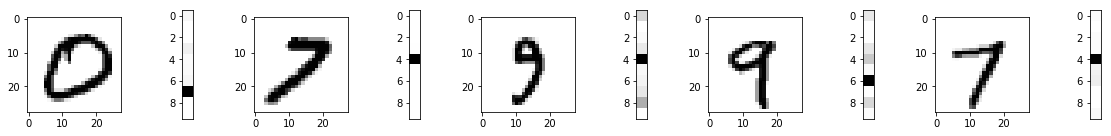

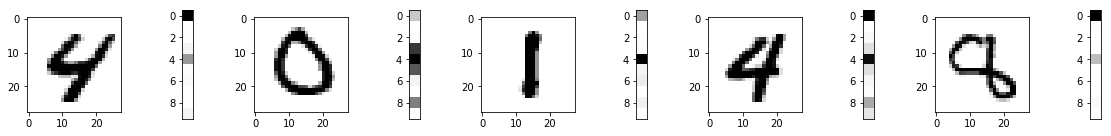

In [124]:
plot_numbers(10,2,features)

0 : 2.376949430111194
5000 : 1.8418592151183588
10000 : 1.7268938014900472
15000 : 1.7451406327256485
20000 : 1.7169685391935592
25000 : 1.622229112378234
30000 : 1.6136686959431
35000 : 1.6102767733254642
40000 : 1.5194194114697246
45000 : 1.511263705285679


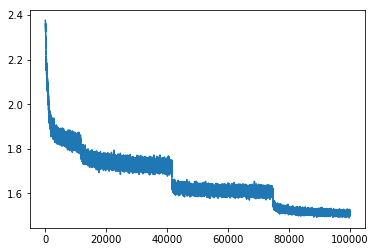

In [125]:
eta = 1
MAX_ITER = 50000
EE = []
batch_size = min(1000,instance_size )
Error = torch.nn.CrossEntropyLoss(reduction='elementwise_mean' )

for epoch in range(MAX_ITER):
    
    idx = np.random.choice(instance_size, size=batch_size, replace=False)
    x = features[idx]
    x = x.transpose(0, 1)
    f = mlp_fun(torch.DoubleTensor(x), Weight, Bias, Func)
    y = Variable(torch.LongTensor(target[idx].reshape([len(idx)])), requires_grad=False)

    # Measure the error
    E = Error(f.transpose(0,1), y)
    EE.append(E.data.numpy())
    
    # Compute the derivative of the error with respect to Weights and Biases
    E.backward() 
    EE.append(E.data.numpy())


    for i in range(D-1):
        Weight[i].data.add_(-eta*Weight[i].grad.data)
        Bias[i].data.add_(-eta*Bias[i].grad.data)
        Weight[i].grad.zero_()
        Bias[i].grad.zero_()

    
    if epoch%5000 == 0: 
        print(epoch,':',E.item())

EE = np.squeeze(EE, axis=(2,))
plt.plot(EE)
plt.show()

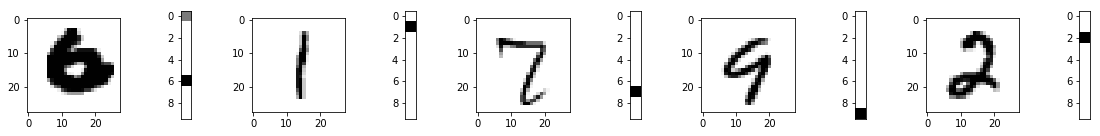

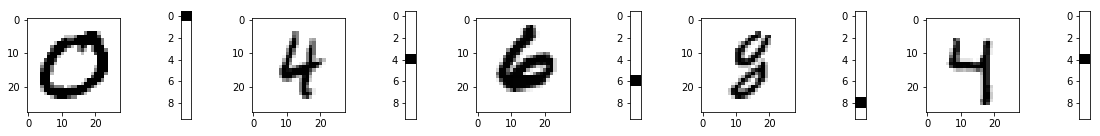

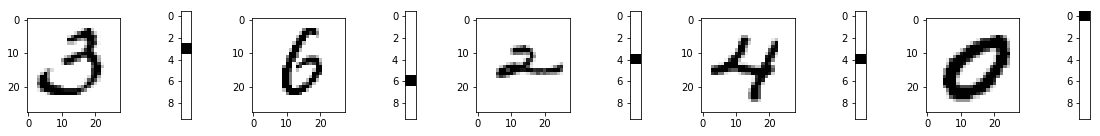

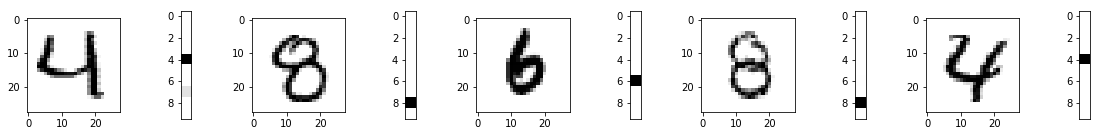

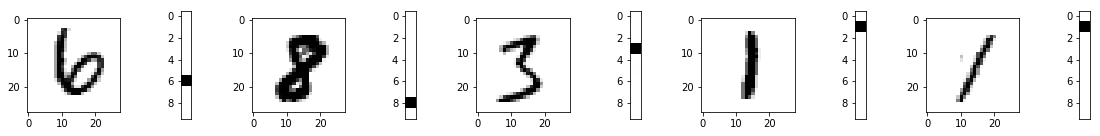

In [126]:
plot_numbers(25,5,features)

In [127]:
def report_result(title, features, target):

    print(title)

    features = features.transpose(0, 1)
    f = mlp_fun(torch.DoubleTensor(features), Weight, Bias, Func)
    Result = f.argmax(0)

    plt.figure(figsize=(15,10))   
    plt.plot(target.data.numpy().squeeze(),'Dr')

    plt.plot(Result.data.numpy().squeeze(),'.')

    
    plt.show()
    
    confusion_matrix = np.zeros((10,10))

    for i in range(len(Result)):
        confusion_matrix[int(target[i]), int(Result[i])] += 1
    
    plt.figure(figsize=(10,10))    

    plt.imshow(confusion_matrix, cmap='gray_r')
    plt.show()

    accuracy = np.sum(np.diag(confusion_matrix))/np.sum(confusion_matrix)

    print("Accuracy:", accuracy*100, "%")

Train Data


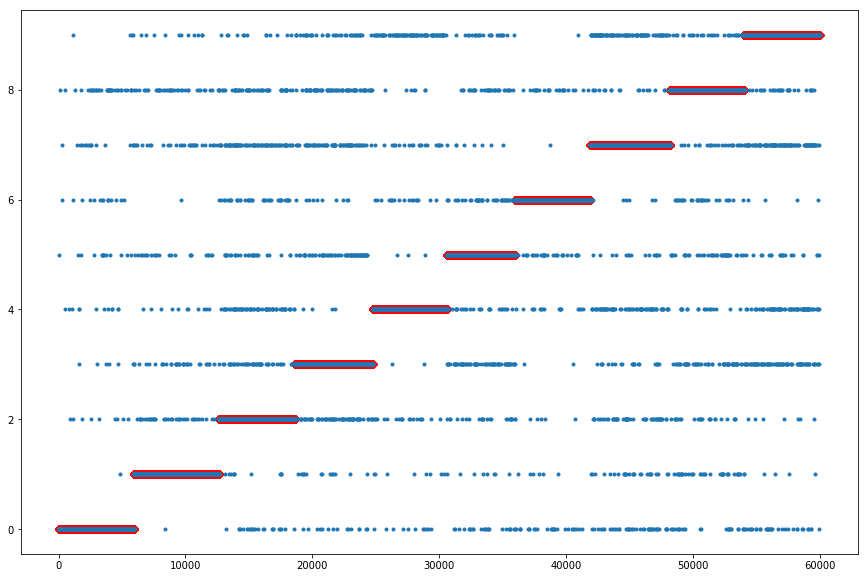

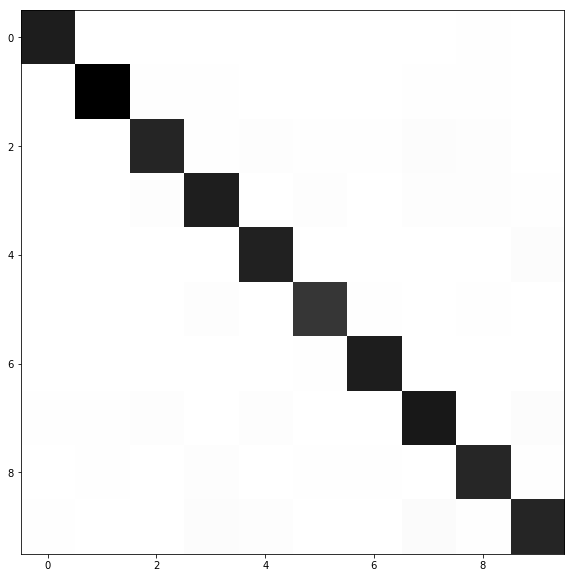

Accuracy: 95.71333333333332 %


In [128]:
report_result("Train Data",features, target)

Test Data


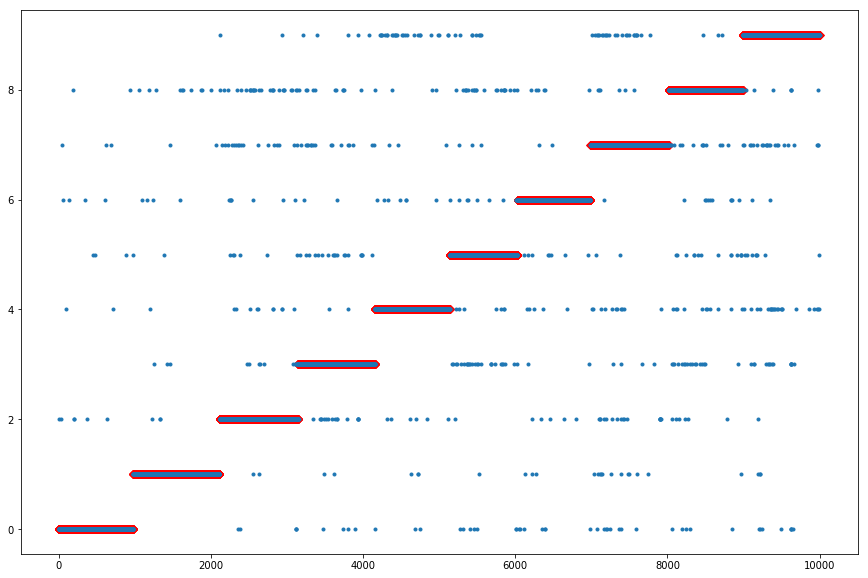

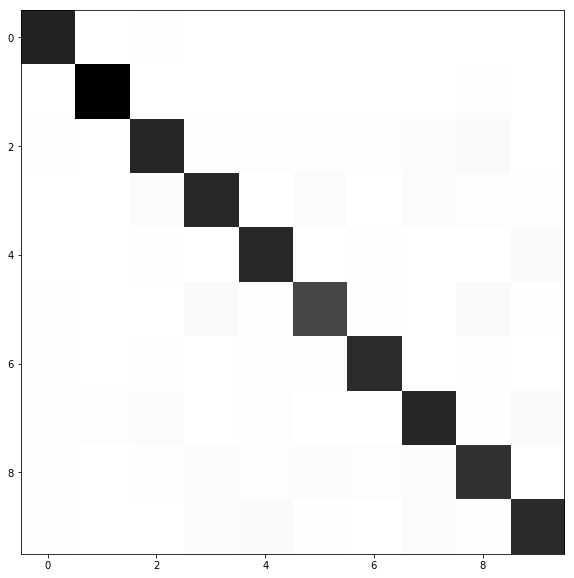

Accuracy: 93.62 %


In [129]:
report_result("Test Data",features_test, target_test)